# Práctica 1. Aprendizaje Automático

Authors: Carlos Iborra Llopis (100451170), Alejandra Galán Arrospide (100451273)


# 0. Table of contents

- [Práctica 1. Aprendizaje Automático](#práctica-1-aprendizaje-automático)
  - [0. Table of contents](#0-table-of-contents)
  - [1. Requirements](#1-requirements)
  - [2. Reading the datasets](#2-reading-the-datasets)
  - [3. Exploratory Data Analysis](#3-EDA)


# 1. Requirements


In [4]:
""" Importing necessary libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
import scipy

from matplotlib.cbook import boxplot_stats as bps


# 2. Reading the datasets

Reading the datasets from the bz2 files, group 2.


In [5]:
""" Reading the dataset """
disp_df = pd.read_csv("../data/disp_st2ns1.txt.bz2",
                      compression="bz2", index_col=0)
comp_df = pd.read_csv("../data/comp_st2ns1.txt.bz2",
                      compression="bz2", index_col=0)


# 3. EDA


**Key Concepts of Exploratory Data Analysis**

- **2 types of Data Analysis**
  - Confirmatory Data Analysis
  - Exploratory Data Analysis
- **4 Objectives of EDA**
  - Discover Patterns
  - Spot Anomalies
  - Frame Hypothesis
  - Check Assumptions
- **2 methods for exploration**
  - Univariate Analysis
  - Bivariate Analysis
- **Stuff done during EDA**
  - Trends
  - Distribution
  - Mean
  - Median
  - Outlier
  - Spread measurement (SD)
  - Correlations
  - Hypothesis testing
  - Visual Exploration


## 3.1. Dataset description

- **apcp_sfc**: 3-Hour accumulated precipitation at the surface (kg·m⁽⁻²⁾)
- **dlwrf_sfc**: Downward long-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **dswrf_sfc**: Downward short-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **pres_msl**: Air pressure at mean sea level (Pa)
- **pwat_eatm**: Precipitable Water over the entire depth of the atmosphere (kg·m⁽⁻²⁾)
- **spfh_2m**: Specific Humidity at 2 m above ground (kg·kg⁽⁻¹⁾)
- **tcdc_eatm**: Total cloud cover over the entire depth of the atmosphere (%)
- **tcolc_eatm**: Total column-integrated condensate over the entire atmos. (kg·m⁽⁻²⁾)
- **tmax_2m**: Maximum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmin_2m**: Mininmum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmp_2m**: Current temperature at 2 m above the ground (K)
- **tmp_sfc**: Temperature of the surface (K)
- **ulwrf_sfc**: Upward long-wave radiation at the surface (W·m⁽⁻²⁾)
- **ulwrf_tatm**: Upward long-wave radiation at the top of the atmosphere (W·m⁽⁻²⁾)
- **uswrf_sfc**: Upward short-wave radiation at the surface (W·m⁽⁻²⁾)


In [6]:
disp_df.describe()


,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,...,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4.380000e+03
mean,0.606809,0.252764,0.480446,0.271476,0.514641,316.698532,317.381851,324.682998,343.757513,343.097254,...,247.300145,251.597699,261.916025,260.870143,0.076235,38.585222,76.064674,126.504047,99.087049,1.629826e+07
std,2.275740,0.999809,1.774720,1.086599,1.886735,55.637609,57.874376,58.702133,60.860672,60.693451,...,36.804219,36.382653,39.190955,38.734023,0.255491,25.984861,30.784078,40.571154,35.454368,7.965298e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,...,113.559602,118.679132,119.393449,121.951425,0.000000,0.000000,3.181818,4.363636,2.545455,5.100000e+05
25%,0.000000,0.000000,0.000000,0.000000,0.000000,271.219564,268.889864,275.709318,293.757163,292.834810,...,230.482578,233.976283,245.721419,243.850282,0.000000,14.000000,53.431818,108.454545,74.795455,1.062375e+07
50%,0.000000,0.000000,0.000000,0.000000,0.000000,321.106932,323.063311,329.708327,346.763388,345.883918,...,253.309217,257.270334,270.790095,269.300432,0.000000,35.363636,79.272727,135.909091,104.818182,1.635690e+07
75%,0.109091,0.051818,0.127500,0.036364,0.090909,366.145476,370.147353,378.509126,399.600853,398.728281,...,274.861445,278.800420,290.139446,289.699652,0.000000,61.818182,102.727273,155.204545,129.545455,2.312775e+07
max,43.009090,16.846364,28.399091,26.381818,36.875455,426.173970,427.486894,429.693146,455.566337,453.910406,...,311.991660,315.569164,328.920274,327.253141,1.000000,92.272727,192.636364,450.636364,313.909091,3.122700e+07


In [7]:
disp_df.shape


(4380, 76)

In [8]:
disp_df.head()


,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
V1,0.0,0.0,0.0,0.000000,0.0,268.583582,244.241641,251.174486,269.741308,268.377441,...,252.504475,254.760271,263.342404,260.067843,0.0,10.000000,50.000000,106.636364,72.000000,11930700
V2,0.0,0.0,0.0,0.008182,0.2,251.725869,255.824126,272.163913,318.259924,307.929083,...,233.458263,233.027276,212.652054,222.052916,0.0,8.181818,35.909091,58.181818,42.090909,9778500
V3,0.0,0.0,0.0,0.000000,0.0,219.734547,211.996022,216.405820,235.529123,239.840132,...,232.828737,235.480750,245.177331,238.893102,0.0,10.272727,55.272727,118.454545,79.181818,9771900
V4,0.0,0.0,0.0,0.000000,0.0,253.499410,230.896544,235.857221,240.274556,237.804048,...,241.916776,243.398572,251.473036,247.503769,0.0,8.909091,46.000000,107.090909,73.636364,6466800
V5,0.0,0.0,0.0,0.000000,0.0,234.890020,238.927051,246.850822,271.577246,275.572826,...,233.706659,239.952805,258.128188,253.200684,0.0,8.909091,48.909091,106.272727,71.818182,11545200


In [9]:
disp_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4380 entries, V1 to V4380
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  4380 non-null   float64
 1   apcp_sf2_1  4380 non-null   float64
 2   apcp_sf3_1  4380 non-null   float64
 3   apcp_sf4_1  4380 non-null   float64
 4   apcp_sf5_1  4380 non-null   float64
 5   dlwrf_s1_1  4380 non-null   float64
 6   dlwrf_s2_1  4380 non-null   float64
 7   dlwrf_s3_1  4380 non-null   float64
 8   dlwrf_s4_1  4380 non-null   float64
 9   dlwrf_s5_1  4380 non-null   float64
 10  dswrf_s1_1  4380 non-null   float64
 11  dswrf_s2_1  4380 non-null   float64
 12  dswrf_s3_1  4380 non-null   float64
 13  dswrf_s4_1  4380 non-null   float64
 14  dswrf_s5_1  4380 non-null   float64
 15  pres_ms1_1  4380 non-null   float64
 16  pres_ms2_1  4380 non-null   float64
 17  pres_ms3_1  4380 non-null   float64
 18  pres_ms4_1  4380 non-null   float64
 19  pres_ms5_1  4380 non-null   fl

## 3.2. Missing values


Fist, we check the number the total number of missing values in the dataset in order to know if we have to clean the dataset or not.

In [10]:
disp_df.isna().sum()


apcp_sf1_1    0
apcp_sf2_1    0
apcp_sf3_1    0
apcp_sf4_1    0
apcp_sf5_1    0
             ..
uswrf_s2_1    0
uswrf_s3_1    0
uswrf_s4_1    0
uswrf_s5_1    0
salida        0
Length: 76, dtype: int64

As we can oberve, there are no missing values in the dataset, but theres still the possibility of having missing values measured as 0's, so we will check if all those zeros make sense in the context of the dataset or not.

<AxesSubplot:>

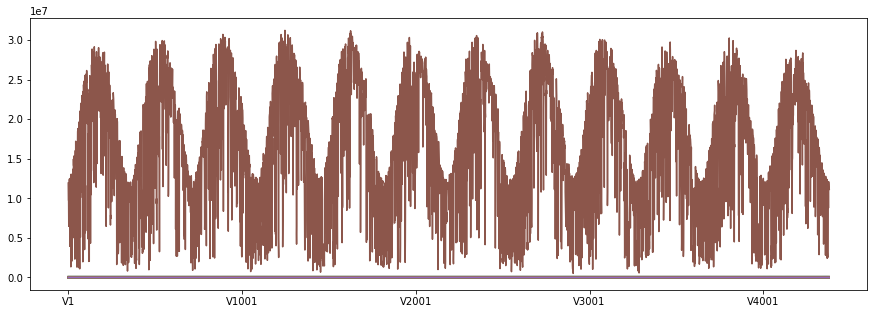

In [11]:
# In the plot, we can see that there are a lot of 0 values in the dataset
disp_df.plot(legend=False, figsize=(15, 5))


In [12]:
result = disp_df.eq(0.0).sum()/len(disp_df)*100

# Select those columns with more than 30% of zeros
result = result[result > 30.0]
result = result.sort_values(ascending=False)
result


dswrf_s1_1    92.054795
uswrf_s1_1    90.844749
apcp_sf4_1    63.378995
apcp_sf5_1    61.278539
apcp_sf1_1    61.164384
apcp_sf2_1    60.296804
apcp_sf3_1    57.305936
tcdc_ea3_1    37.945205
tcdc_ea1_1    37.237443
tcdc_ea2_1    37.123288
tcdc_ea5_1    36.004566
tcdc_ea4_1    35.547945
dtype: float64

### Observations

As output of the previous cell, we can see that there exist a lot of zeros in the dataset, let's analize if those zeros make sense or not.

The variables with most ammount of zeros (>30%) are:

- **dswrf_s1_1**: Downward short-wave radiative flux average at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **uswrf_s1_1**: Upward short-wave radiation at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **apcp_s**: 3-Hour accumulated precipitation at the surface, as it is not raining every day, it is normal to have a lot of zeros
- **tcdc_ea**: Total cloud cover over the entire depth of the atmosphere, as it is not cloudy every day, it is normal to have a lot of zeros


First, lets start by assigning the zeros to NaNs. By doing this we can visualize the varibles that take more values other than zero.


In [13]:
disp_df_nan = disp_df.replace(0.0, np.nan)


c:\Users\ALEJANDRA\anaconda3\lib\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (76).

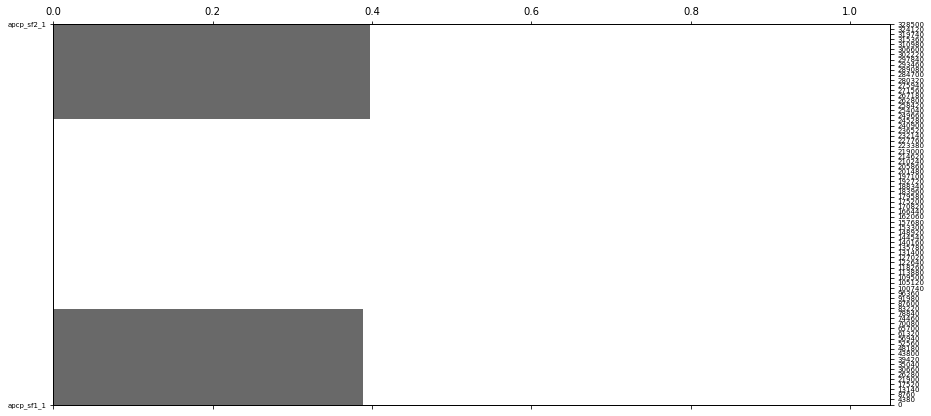

In [14]:
""" Plotting missing values """
# Sustitute 0.0 values with NaN and plot the name of the columns with missing values
# ? msno.bar is a simple visualization of nullity by column
msno.bar(disp_df_nan, labels=True, fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_bar.png")


In [ ]:
""" Plotting the missing values in a matrix """
# ? The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.
msno.matrix(disp_df_nan, labels=True, fontsize=7, figsize=(15, 7), color=(.3, .3, .3))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_matrix.png")


NameError: name 'msno' is not defined

In [ ]:
""" Plotting the missing values in a heatmap """
# As in a hetmap not every value is shown, we must delimit the values to the ones with more than 30% of missing values
result = disp_df.eq(0.0).sum()/len(disp_df)*100
result = result[result > 30.0] # Select those columns with more than 30% of zeros
result = result.sort_values(ascending=False)
result = result.index.tolist() # Convert to list
result

# ? The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
msno.heatmap(disp_df_nan[result], fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_heatmap.png")


NameError: name 'disp_df' is not defined

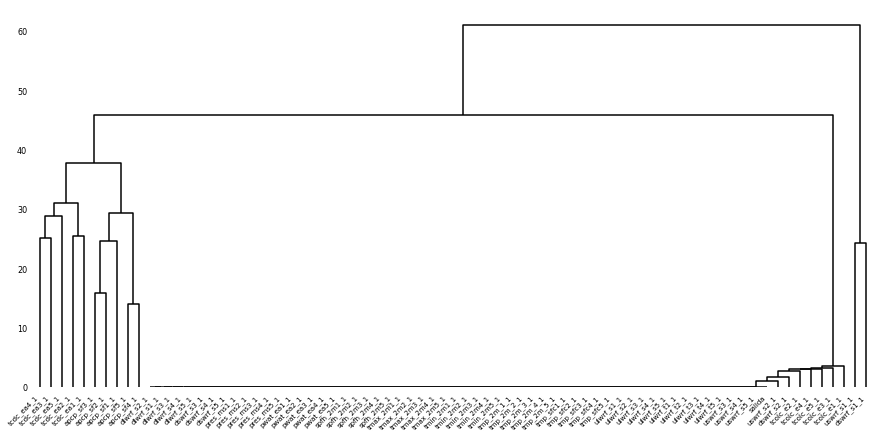

In [16]:
""" Plotting the dendrogram """

# ? The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:
msno.dendrogram(disp_df_nan, orientation="top",fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_dendrogram.png")


### Conclusions
In this section, we have observe that there are no attibutes with 'Null' nor 'NaN' nor 'None' values. This indicated that at a first glance, the data is clean, at least of those datatypes.

In second place, we have observed that the attributes that we suspected could have an important number of missing values (represented by 0 instead of the previously mentioned), had instead valuable information, as we have proved along this section.<br>Since the data is clean and we have concluded there are no missing values, we do not need to complete them using a model or other methods, so we can move on to the next step, observing the outliers.

## 3.3. Outliers


With the objective of noticing the outliers on each attribute, we create a box-plot of each of the attributes 

In [18]:
list_of_attributes = disp_df.columns.values.tolist()
#print(list_of_attributes)

In [19]:
## Boxplot with all attributes in the dataset
#sns.boxplot(data=disp_df, orient="h")
#plt.show()

In [20]:
disp_df.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,...,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4.380000e+03
mean,0.606809,0.252764,0.480446,0.271476,0.514641,316.698532,317.381851,324.682998,343.757513,343.097254,...,247.300145,251.597699,261.916025,260.870143,0.076235,38.585222,76.064674,126.504047,99.087049,1.629826e+07
std,2.275740,0.999809,1.774720,1.086599,1.886735,55.637609,57.874376,58.702133,60.860672,60.693451,...,36.804219,36.382653,39.190955,38.734023,0.255491,25.984861,30.784078,40.571154,35.454368,7.965298e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,...,113.559602,118.679132,119.393449,121.951425,0.000000,0.000000,3.181818,4.363636,2.545455,5.100000e+05
25%,0.000000,0.000000,0.000000,0.000000,0.000000,271.219564,268.889864,275.709318,293.757163,292.834810,...,230.482578,233.976283,245.721419,243.850282,0.000000,14.000000,53.431818,108.454545,74.795455,1.062375e+07
50%,0.000000,0.000000,0.000000,0.000000,0.000000,321.106932,323.063311,329.708327,346.763388,345.883918,...,253.309217,257.270334,270.790095,269.300432,0.000000,35.363636,79.272727,135.909091,104.818182,1.635690e+07
75%,0.109091,0.051818,0.127500,0.036364,0.090909,366.145476,370.147353,378.509126,399.600853,398.728281,...,274.861445,278.800420,290.139446,289.699652,0.000000,61.818182,102.727273,155.204545,129.545455,2.312775e+07
max,43.009090,16.846364,28.399091,26.381818,36.875455,426.173970,427.486894,429.693146,455.566337,453.910406,...,311.991660,315.569164,328.920274,327.253141,1.000000,92.272727,192.636364,450.636364,313.909091,3.122700e+07


In [ ]:
## disp_df['apcp_sf1_1'].value_counts()

Here, by plotting the boxplots and making the outliers (fliers) visible, we are able to see some outliers in the dataset.<br>
Take into account that the outliers are represented by the points outside the boxplot and they can be potentially wrong values or just values that are not usual in the dataset (ruido).

['apcp_sf1_1 outliers', 839, [1.11909090930765, 0.358181819997051, 2.46363633329218, 0.510000003332442, 1.12363637577404, 26.886363549666, 0.942727267742157, 1.08727271990343, 11.872727134011, 0.358181823383678, 0.2845454569906, 4.84181818095121, 6.9500000260093, 5.18909092382951, 7.09727272120389, 0.916363634846427, 0.448181818832051, 3.9127273153175, 3.16363642432473, 1.2427272695032, 2.06454543633894, 6.27000004188581, 1.0327272862196, 0.31909091161056, 2.17272726785053, 0.876363634724509, 2.17636364630678, 0.487272722815925, 1.37545453960245, 1.01727271080017, 0.504545454274524, 1.41818179122426, 8.4618182182312, 1.12727272510529, 4.05181815881621, 0.94454545324499, 4.33272725885565, 0.670000000433488, 0.358181819997051, 0.418181818994609, 10.9018183621493, 0.512727274474773, 3.700909094377, 5.45909088308161, 0.351818186992949, 1.35636362907561, 0.296363632787358, 0.409090909768235, 6.56000002947721, 6.44272729483518, 2.39000003039837, 1.08272727240216, 3.78181821649725, 0.45545454

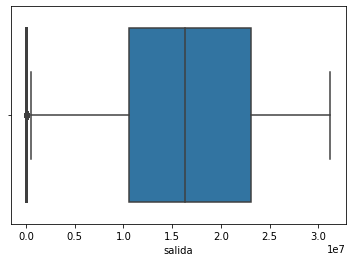

In [21]:
""" Plotting the boxplot for each attribute and getting the outliers of each attribute """
total_outliers = []
# * We iterate over the list of attributes
for attribute in list_of_attributes:
    # * sns.regplot(x=disp_df[attribute], y=disp_df['total'], fit_reg=False)
    sns.boxplot(data=disp_df[attribute], x=disp_df[attribute], orient="h")
    # * Use the command below to show each plot (small size for visualization sake)
    # sns.set(rc={'figure.figsize':(1,.5)})
    # plt.show()
    # * All the images are saved in the folder ../data/img/box-plot
    plt.savefig(f"../data/img/box-plot/{str(attribute)}.png")

    # We obtain the a list of outliers for each attribute
    list_of_outliers = disp_df[attribute][disp_df[attribute] > disp_df[attribute].quantile(0.75) + 1.5*(disp_df[attribute].quantile(0.75) - disp_df[attribute].quantile(0.25))].tolist()
    outliers = [f'{attribute} outliers'] + [len(list_of_outliers)] + [list_of_outliers]
    # * In orde to print the total number of outliers for each attribute
    # print(f'{attribute} has {len(list_of_outliers)} outliers')
    # ! Data structure: [attribute, number of outliers, list of outliers]
    print(outliers)
    total_outliers.append(outliers)

print(total_outliers)


We managed to create a list containing the name of the atribute, the number of outliers and the value of the outliers for each attribute, calculated by applying the IQR method.<br> This is relevant as we managed to create a 'total_outliers' variable that contains the list data structures of all the different outliers from all the attributes, so that it can be easily accessed in a future to remove the outliers from the dataset if needed for testing purposes.

As suspected, we can see that there are a lot of outliers in the dataset, therefore it is plausible that some of them are noise, thus possibly being removed in a future model in order to improve it.<br>Now, we need to analyze if they are the result of bad measurements or if they are significant data for the analysis.


In [22]:
""" Skewness """
# ? skewness: measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
disp_df.skew().sort_values(ascending=False)

apcp_sf4_1    9.232876
apcp_sf2_1    7.550050
apcp_sf1_1    7.402803
apcp_sf3_1    7.265894
apcp_sf5_1    7.195886
                ...   
ulwrf_t1_1   -0.965765
ulwrf_t3_1   -0.997749
ulwrf_t2_1   -1.007615
ulwrf_t5_1   -1.055472
ulwrf_t4_1   -1.181864
Length: 76, dtype: float64

In [23]:
""" Kurtosis """
# ? kurtosis: measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
disp_df.kurt().sort_values(ascending=False)

apcp_sf4_1    137.078212
apcp_sf1_1     78.306178
apcp_sf2_1     76.959166
apcp_sf5_1     76.901878
apcp_sf3_1     70.852519
                 ...    
uswrf_s2_1     -1.303016
spfh_2m2_1     -1.318701
spfh_2m5_1     -1.319063
dswrf_s2_1     -1.321058
spfh_2m3_1     -1.324692
Length: 76, dtype: float64

c:\Users\ALEJANDRA\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\ALEJANDRA\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Log Normal'}, xlabel='apcp_sf4_1', ylabel='Density'>

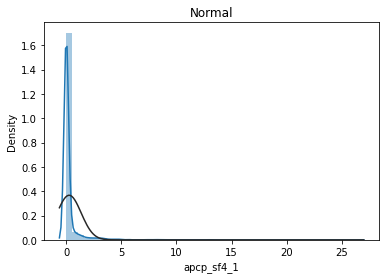

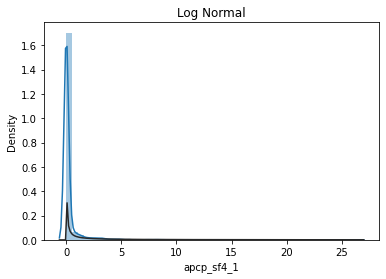

In [24]:
y = disp_df['apcp_sf4_1']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=True, fit=st.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=True, fit=st.lognorm)

c:\Users\ALEJANDRA\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Skewness', ylabel='Density'>

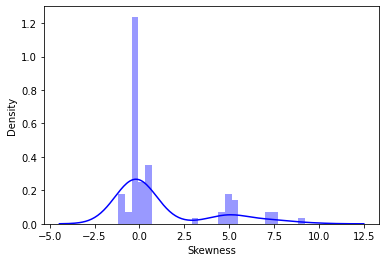

In [25]:
sns.distplot(disp_df.skew(),color='blue',axlabel ='Skewness')

c:\Users\ALEJANDRA\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


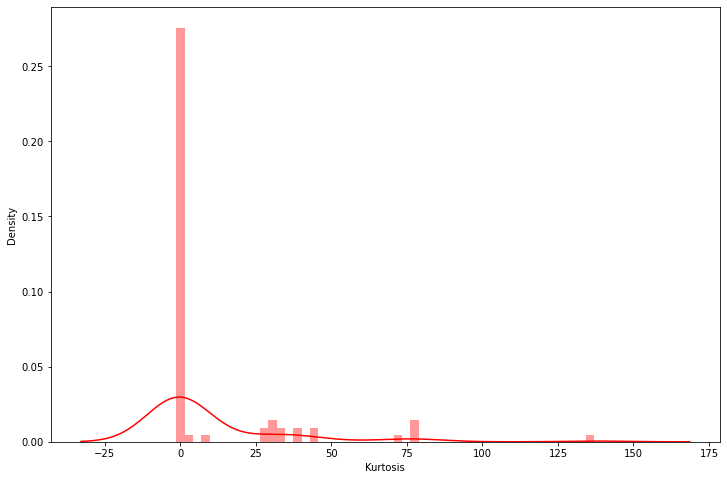

In [26]:
plt.figure(figsize = (12,8))
sns.distplot(disp_df.kurt(),color='r',axlabel ='Kurtosis',norm_hist= False, kde = True,rug = False)
#plt.hist(train.kurt(),orientation = 'vertical',histtype = 'bar',label ='Kurtosis', color ='blue')
plt.show()

## 3.4. Correlation


In this section we are getting information about the correlation of the variables between them. This information is valuable in order to make good decisions when deleting redundant attributes. Also note we are getting information about the correlation between each attribute and the solution variable. This allows us to know the most relevant attributes, making the best decisions when creating the different models.  

In [30]:
correlation = disp_df.corr()
correlation = abs(correlation)
print(correlation)  # 76 x 76 matrix of correlation values

            apcp_sf1_1  apcp_sf2_1  apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  \
apcp_sf1_1    1.000000    0.587239    0.509665    0.249329    0.255535   
apcp_sf2_1    0.587239    1.000000    0.926354    0.394384    0.379884   
apcp_sf3_1    0.509665    0.926354    1.000000    0.574310    0.533648   
apcp_sf4_1    0.249329    0.394384    0.574310    1.000000    0.928523   
apcp_sf5_1    0.255535    0.379884    0.533648    0.928523    1.000000   
...                ...         ...         ...         ...         ...   
uswrf_s2_1    0.161360    0.204639    0.212301    0.135941    0.148588   
uswrf_s3_1    0.228271    0.313188    0.343573    0.252657    0.272716   
uswrf_s4_1    0.181360    0.279789    0.340832    0.350630    0.371776   
uswrf_s5_1    0.145594    0.235880    0.291234    0.309841    0.335141   
salida        0.171532    0.248745    0.282336    0.249886    0.275859   

            dlwrf_s1_1  dlwrf_s2_1  dlwrf_s3_1  dlwrf_s4_1  dlwrf_s5_1  ...  \
apcp_sf1_1    0.252467    0.2294

### Getting the correlation matrix formatted into our own data structure
This is done for the sake of simplicity and to be able to visualize the correlation matrix in a more intuitive way.


In [31]:
correlation_list = []

for column in disp_df:
    correlation[column] = abs(correlation[column])
    mask = correlation[column] > 0.95
    # print(correlation[column][mask].sort_values(ascending = False))
    
    # Translate the comment below to English: 
    # we add the correlation values to a list of lists, which contains the names of the correlated columns and their correlation index
    
    # The first segment adds the name of the column we are analyzing
    # The second segment adds the names of the columns correlated (except the column we are analyzing) > 0.95
    # The third segment adds the correlation index of the columns correlated (except the column we are analyzing) > 0.95
    # Second and third segment are added to the first segment as a list of lists
    
    # First we need to create a dictionary with the column names and their correlation values (except the column we are analyzing)
    dict = ({key: value for key, value in correlation[column][mask].sort_values(ascending = False).to_dict().items() if key != column})
    # print (dict)
    
    # Then we create a list of lists with the column names and their correlation values from the dictionary created above
    corr_list = [[key] + [value] for key, value in dict.items()]
    # Finally we add the name of the column we are analyzing to the list of lists created above as the first element of the list (str)
    corr_list.insert(0, f"Columna: {column}")
    
    # ! Data structure: [[columna, [columna correlada 1, indice de correlacion], [columna correlada 2, indice de correlacion], ...], ...] 
    print(corr_list)
    
    correlation_list += [corr_list]
print(correlation_list)

['Columna: apcp_sf1_1']
['Columna: apcp_sf2_1']
['Columna: apcp_sf3_1']
['Columna: apcp_sf4_1']
['Columna: apcp_sf5_1']
['Columna: dlwrf_s1_1', ['dlwrf_s2_1', 0.9654602451282467], ['dlwrf_s3_1', 0.9555714275535937]]
['Columna: dlwrf_s2_1', ['dlwrf_s3_1', 0.993801937354884], ['dlwrf_s1_1', 0.9654602451282467]]
['Columna: dlwrf_s3_1', ['dlwrf_s2_1', 0.993801937354884], ['dlwrf_s4_1', 0.9664287191255341], ['dlwrf_s5_1', 0.955638710623432], ['dlwrf_s1_1', 0.9555714275535937]]
['Columna: dlwrf_s4_1', ['dlwrf_s5_1', 0.9968432736329301], ['dlwrf_s3_1', 0.9664287191255341]]
['Columna: dlwrf_s5_1', ['dlwrf_s4_1', 0.9968432736329301], ['dlwrf_s3_1', 0.955638710623432]]
['Columna: dswrf_s1_1']
['Columna: dswrf_s2_1', ['uswrf_s2_1', 0.9912815245133624], ['dswrf_s3_1', 0.9503100565387964]]
['Columna: dswrf_s3_1', ['uswrf_s2_1', 0.9591543590605579], ['dswrf_s2_1', 0.9503100565387964]]
['Columna: dswrf_s4_1', ['dswrf_s5_1', 0.9825798647066863]]
['Columna: dswrf_s5_1', ['dswrf_s4_1', 0.982579864706686

### Correlation Heat Map

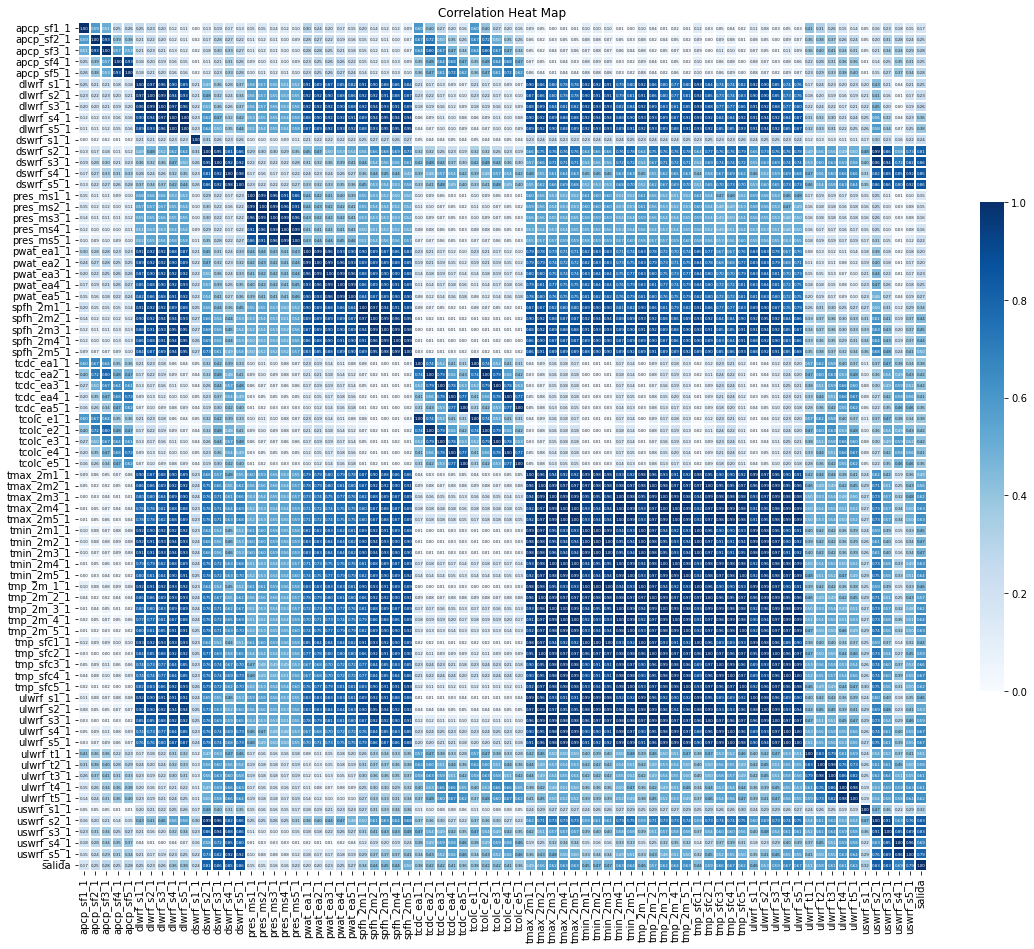

In [32]:
""" seaborne Correlation Heat Map """

# It needs to show all the columns
fig, ax = plt.subplots(figsize=(19,18))

plt.title('Correlation Heat Map',y=1)
# We use blue color scale because it is easier to see the annotations and the correlation values
sns.heatmap(correlation, square=True, cmap='Blues', annot=True, fmt='.2f', annot_kws={'size': 4}, linewidths=.3, cbar_kws={"shrink": .5}, vmin=0.0, vmax=1)
# We can modify vmax=0.95 in order to get same color scale for values with more than 0.95 correlation
# Note: it delays around 15 seconds as it needs to plot a 76*76 matrix with its 5766 correlation values

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/correlation_heatmap.png", dpi=200)


Once obtained the most correlated columns of the dataset, we can plot them and visualize their correlation.

c:\Users\ALEJANDRA\anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


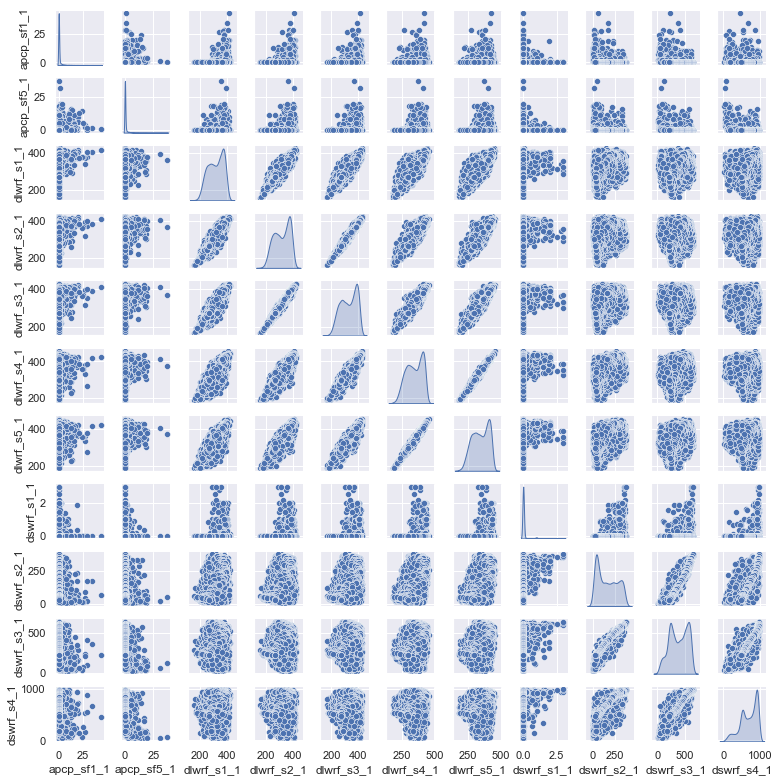

In [33]:
sns.set()
columns = []

# We get all the columns -- lot of time (76x76)
# for column in disp_df:
#     columns.append(column)
# print(columns)

columns = ['apcp_sf1_1', 'apcp_sf5_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1', 'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1']

sns.pairplot(disp_df[columns], size = 1 ,kind ='scatter',diag_kind='kde')
plt.show()


As we can observe in the graphs above, the most correlated variables present a linear relationship between them. This shows as a diagonal in the graph, since both variables grow at the same time. 